# Prepare

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Membaca data dari file CSV
df = pd.read_csv('tokopedia_review_filter_.csv')

# Menghapus baris yang memiliki nilai NaN (null) pada kolom 'comment'
df = df.dropna(subset=['review'])
df = df.drop_duplicates(subset=['review'])

df

,user,waktu,barang,review,rating
0,K***a,02/04/2024,Roma Wafello Renceng isi 10 sct,barang sesuai pesanan.. kemasan aman.. makasi ...,5
1,K***a,02/04/2024,Slai Olai Biskuit 240gr,barang dtg sesuai pesanan.. kondisi baik...kem...,5
2,Ririn,02/04/2024,indofood kecap manis botol 135ml,mantapp dpt hrga diskon jd murah bgt.. packing...,5
4,F***y,28/03/2024,Soklin Liquid Detergent 22ml Renceng ( isi 24 ...,"pesan korean camelia, tapi yang dikirim violet...",4
5,Agus,27/03/2024,abc kopi susu renceng,kopi sudah sampai dengan selamat dan aman,5
...,...,...,...,...,...
2880,t***i,10/03/2023,Nuvo hand sanitizer 50ml gel,pelayanan &amp; barang oke,5
2881,tari,10/03/2023,Nuvo hand sanitizer 50ml gel,"pelayanan oke, barang yang sampe sesuai pesana...",5
2882,M***n,10/03/2023,Nuvo hand sanitizer 50ml gel,sesuai dengan barang yang dipasang fotonya. Bt...,5
2883,Duhita,10/03/2023,Nuvo hand sanitizer 50ml gel,"fast respon,ramah,packing aman,barang sesuai,h...",5


In [3]:
data = df[['review', 'rating']]

# Sentiment Analysis Using Naive Bayes

## Preprocessing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle
import re
import seaborn as sn

%matplotlib inline

In [5]:
!pip -q install sastrawi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Casefolding

In [6]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = re.sub(r'\n', ' ', text)                      # Menghilangkan Enter
  text = text.lower()                               # Mengubah huruf menjadi huruf kecil
  text = text.replace(":", " ")                      # Hapus :
  text = re.sub(r'https?://\S+|www\.\S+', ' ', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', ' ', text)           # Menghapus angka
  text = re.sub(r'[^\w\s*]',' ', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespace di awal dan d akhir
  return text

data["casefolding"] = data["review"].apply(lambda x: casefolding(x))
data.head()

,review,rating,casefolding
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesanan kemasan aman makasi ...
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesanan kondisi baik kem...
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantapp dpt hrga diskon jd murah bgt packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia tapi yang dikirim violet...
5,kopi sudah sampai dengan selamat dan aman,5,kopi sudah sampai dengan selamat dan aman


In [7]:
data.to_excel('casefolding.xlsx')


### Normalisasi kata

sumber:
https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

In [9]:
key_norm = pd.read_csv("key_norm.csv")
def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
    text = str.lower(text)
    return text
data['textnormalize'] = data['casefolding'].apply(text_normalize)
data.head()

,review,rating,casefolding,textnormalize
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesanan kemasan aman makasi ...,barang sesuai pesanan kemasan aman makasi penjual
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesanan kondisi baik kem...,barang dtg sesuai pesanan kondisi baik kemasan...
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantapp dpt hrga diskon jd murah bgt packing...,mantap dpt hrga diskon jd murah banget packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia tapi yang dikirim violet...,pesan korean camelia tapi yang dikirim violet ...
5,kopi sudah sampai dengan selamat dan aman,5,kopi sudah sampai dengan selamat dan aman,kopi sudah sampai dengan selamat dan aman


In [10]:
data.to_excel('norm.xlsx')


### Stopwords Removal

In [11]:
# download Stopwords bahasa indonesia
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nanan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [13]:
def remove_stop_words(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)
data['stopwordremoval'] = data['textnormalize'].apply(remove_stop_words)
data.head()

,review,rating,casefolding,textnormalize,stopwordremoval
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesanan kemasan aman makasi ...,barang sesuai pesanan kemasan aman makasi penjual,barang sesuai pesanan kemasan aman makasi penjual
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesanan kondisi baik kem...,barang dtg sesuai pesanan kondisi baik kemasan...,barang dtg sesuai pesanan kondisi kemasan maka...
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantapp dpt hrga diskon jd murah bgt packing...,mantap dpt hrga diskon jd murah banget packing...,mantap dpt hrga diskon jd murah banget packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia tapi yang dikirim violet...,pesan korean camelia tapi yang dikirim violet ...,pesan korean camelia dikirim violet blosom
5,kopi sudah sampai dengan selamat dan aman,5,kopi sudah sampai dengan selamat dan aman,kopi sudah sampai dengan selamat dan aman,kopi selamat aman


In [14]:
data.to_excel('stopwords.xlsx')


### Stemming

stemmming adalah menghilangkan kata depan dan kata belakang contohnya

Menghidupkan -> hidup

Module yang digunakan untuk bahasa indonesia adalah Sastrawi

In [15]:
pip install Sastrawi

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    text = stemmer.stem(text)
    return text
data['stemming'] = data['stopwordremoval'].apply(stemming)
data.head()

,review,rating,casefolding,textnormalize,stopwordremoval,stemming
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesanan kemasan aman makasi ...,barang sesuai pesanan kemasan aman makasi penjual,barang sesuai pesanan kemasan aman makasi penjual,barang sesuai pesan kemas aman makas jual
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesanan kondisi baik kem...,barang dtg sesuai pesanan kondisi baik kemasan...,barang dtg sesuai pesanan kondisi kemasan maka...,barang dtg sesuai pesan kondisi kemas makas jual
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantapp dpt hrga diskon jd murah bgt packing...,mantap dpt hrga diskon jd murah banget packing...,mantap dpt hrga diskon jd murah banget packing...,mantap dpt hrga diskon jd murah banget packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia tapi yang dikirim violet...,pesan korean camelia tapi yang dikirim violet ...,pesan korean camelia dikirim violet blosom,pesan korean camelia kirim violet blosom
5,kopi sudah sampai dengan selamat dan aman,5,kopi sudah sampai dengan selamat dan aman,kopi sudah sampai dengan selamat dan aman,kopi selamat aman,kopi selamat aman


In [17]:
data.to_excel('stemming.xlsx')


In [18]:
data.head()

,review,rating,casefolding,textnormalize,stopwordremoval,stemming
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesanan kemasan aman makasi ...,barang sesuai pesanan kemasan aman makasi penjual,barang sesuai pesanan kemasan aman makasi penjual,barang sesuai pesan kemas aman makas jual
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesanan kondisi baik kem...,barang dtg sesuai pesanan kondisi baik kemasan...,barang dtg sesuai pesanan kondisi kemasan maka...,barang dtg sesuai pesan kondisi kemas makas jual
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantapp dpt hrga diskon jd murah bgt packing...,mantap dpt hrga diskon jd murah banget packing...,mantap dpt hrga diskon jd murah banget packing...,mantap dpt hrga diskon jd murah banget packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia tapi yang dikirim violet...,pesan korean camelia tapi yang dikirim violet ...,pesan korean camelia dikirim violet blosom,pesan korean camelia kirim violet blosom
5,kopi sudah sampai dengan selamat dan aman,5,kopi sudah sampai dengan selamat dan aman,kopi sudah sampai dengan selamat dan aman,kopi selamat aman,kopi selamat aman


In [19]:
data["clean_text"] = data['stemming']
data.drop(["casefolding","textnormalize","stopwordremoval","stemming"],axis=1,inplace=True)
data.head()

,review,rating,clean_text
0,barang sesuai pesanan.. kemasan aman.. makasi ...,5,barang sesuai pesan kemas aman makas jual
1,barang dtg sesuai pesanan.. kondisi baik...kem...,5,barang dtg sesuai pesan kondisi kemas makas jual
2,mantapp dpt hrga diskon jd murah bgt.. packing...,5,mantap dpt hrga diskon jd murah banget packing...
4,"pesan korean camelia, tapi yang dikirim violet...",4,pesan korean camelia kirim violet blosom
5,kopi sudah sampai dengan selamat dan aman,5,kopi selamat aman


### Hapus clean text yang kosong

In [20]:
data = data[data["clean_text"]!=""]
data.drop(columns=['review'], inplace=True)
data

,rating,clean_text
0,5,barang sesuai pesan kemas aman makas jual
1,5,barang dtg sesuai pesan kondisi kemas makas jual
2,5,mantap dpt hrga diskon jd murah banget packing...
4,4,pesan korean camelia kirim violet blosom
5,5,kopi selamat aman
...,...,...
2880,5,layan amp barang oke
2881,5,layan oke barang sesuai pesan ga rusak packing...
2882,5,sesuai barang pasang foto ngomong ngomong dah ...
2883,5,fast respon ramah packing aman barang sesuai h...


In [21]:
def labeling(x):
  if x == 1 or x == 2:
    return "negatif"
  elif x == 3:
    return "netral"
  elif x == 4 or x == 5:
    return "positif"

# Menerapkan fungsi labeling ke kolom 'rating' untuk membuat kolom baru 'sentimen'
data['sentimen'] = df['rating'].apply(labeling)

# Menampilkan dataframe yang sudah difilter dan kolom 'sentimen' yang baru
data

,rating,clean_text,sentimen
0,5,barang sesuai pesan kemas aman makas jual,positif
1,5,barang dtg sesuai pesan kondisi kemas makas jual,positif
2,5,mantap dpt hrga diskon jd murah banget packing...,positif
4,4,pesan korean camelia kirim violet blosom,positif
5,5,kopi selamat aman,positif
...,...,...,...
2880,5,layan amp barang oke,positif
2881,5,layan oke barang sesuai pesan ga rusak packing...,positif
2882,5,sesuai barang pasang foto ngomong ngomong dah ...,positif
2883,5,fast respon ramah packing aman barang sesuai h...,positif


In [22]:
data.to_excel('label.xlsx')

In [23]:
data = data[data["clean_text"]!=""]
data = data[data['sentimen'] != 'netral']
data

,rating,clean_text,sentimen
0,5,barang sesuai pesan kemas aman makas jual,positif
1,5,barang dtg sesuai pesan kondisi kemas makas jual,positif
2,5,mantap dpt hrga diskon jd murah banget packing...,positif
4,4,pesan korean camelia kirim violet blosom,positif
5,5,kopi selamat aman,positif
...,...,...,...
2880,5,layan amp barang oke,positif
2881,5,layan oke barang sesuai pesan ga rusak packing...,positif
2882,5,sesuai barang pasang foto ngomong ngomong dah ...,positif
2883,5,fast respon ramah packing aman barang sesuai h...,positif


### Wordcloud

In [26]:
pip install wordcloud

     -------------------------------------- 300.7/300.7 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


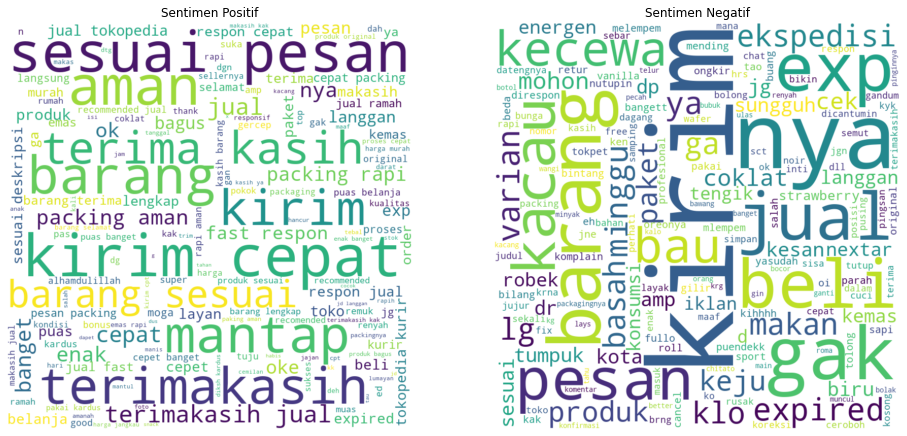

In [27]:
from wordcloud import WordCloud

data_positif = data[data['sentimen'] == 'positif']
data_negatif = data[data['sentimen'] == 'negatif']

text_positif = ' '.join(data_positif["clean_text"].values.tolist())

text_negatif = ' '.join(data_negatif["clean_text"].values.tolist())

wordcloud_positif = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=None,
                              min_font_size=10).generate(text_positif)

wordcloud_negatif = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=None,
                              min_font_size=10).generate(text_negatif)

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positif, interpolation='bilinear')
plt.title('Sentimen Positif')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negatif, interpolation='bilinear')
plt.title('Sentimen Negatif')
plt.axis('off')

plt.show()


In [28]:
data['sentimen'].value_counts()

positif    1581
negatif      24
Name: sentimen, dtype: int64

## Splitting the data

In [29]:
#memisahkan menjadi 2 bagian, 80% data latih dan 20% data uji
from sklearn.model_selection import train_test_split

X_raw = data["clean_text"]
y_raw = data["sentimen"]
X_train, X_test, y_train, y_test = train_test_split(X_raw.values, y_raw.values, test_size=0.2, random_state=42)

## TF-IDF

In [30]:
#tahap merubah data menjadi bilangan vektor
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train)

TfidfVectorizer(ngram_range=(1, 2))

In [31]:
X_train_TFIDF = vectorizer.transform(X_train).toarray()
X_test_TFIDF = vectorizer.transform(X_test).toarray()
X = vectorizer.transform(data["clean_text"]).toarray()
kolom = vectorizer.get_feature_names_out()
train_tf_idf = pd.DataFrame(X_train_TFIDF, columns=kolom)
test_tf_idf = pd.DataFrame(X_test_TFIDF, columns=kolom)
train_tf_idf.head()

,aaaaa,aaaaa suka,aamiin,abiss,abiss hahah,abisss,abisss pakai,acara,acara bingung,adekku,...,yummmy,yummmy jual,yummy,yummy dr,yummy respon,yupi,yupi isi,yupi pilih,zip,zjzjaystaua
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature Selection

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_features = SelectKBest(chi2, k=500)
X_kbest_features = chi2_features.fit_transform(train_tf_idf, y_train)

print('Banyaknya fitur awal:', train_tf_idf.shape[1])
print('banyaknya fitur setelah di seleksi:', X_kbest_features.shape[1])


Banyaknya fitur awal: 4977
banyaknya fitur setelah di seleksi: 500


## Naive Bayes

In [39]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(X_kbest_features,y_train)

GaussianNB()

              precision    recall  f1-score   support

     negatif       0.18      0.40      0.25         5
     positif       0.99      0.97      0.98       316

    accuracy                           0.96       321
   macro avg       0.59      0.69      0.62       321
weighted avg       0.98      0.96      0.97       321



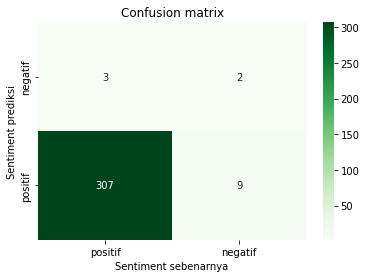

In [40]:
from sklearn.metrics import classification_report,confusion_matrix

X_test_chi2 = chi2_features.transform(X_test_TFIDF)
y_pred = NB.predict(X_test_chi2)
print(classification_report(y_test, y_pred))

columns = ['negatif', 'positif']
confm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Greens', annot=True, fmt=".0f")
ax.set_title('Confusion matrix')
ax.set_xlabel('Sentiment sebenarnya')
ax.set_ylabel('Sentiment prediksi')

# Pindahkan label pada sumbu x (sentimen prediksi) ke kanan
# wighted avg bobot pada setiap kelas
ax.invert_xaxis()

plt.show()

In [ ]:
data_baru = [
    ["Produk ini sangat bagus dan memuaskan. Sangat jelek banget pelayanannya dsaar bego bodoh goblok!"],
    ["Goblok banget Jelek cacad tokonya"],
    ["Kualitas produknya luar biasa. Tidak mengecewakan sama sekali."],
    ["Sangat senang dengan pembelian ini. Produk sesuai dengan ekspektasi saya."],
    ["Saya sangat suka dengan produk ini. Harganya juga terjangkau."],
    ["Pengiriman cepat dan barangnya berkualitas. Terima kasih atas pelayanannya!"],
    ["Setiap kali belanja di sini selalu puas. Barangnya berkualitas dan pelayanannya ramah."],
    ["Barangnya bagus dan sesuai dengan deskripsi. Pengiriman juga tepat waktu."],
    ["Saya sungguh merekomendasikan produk ini kepada teman-teman. Sangat puas dengan kualitasnya."],
    ["Pembelian ini benar-benar membuat saya senang. Produknya bagus dan layanannya memuaskan."]
]

# Buat DataFrame dari data dummy
data_baru = pd.DataFrame(data_baru, columns=['review'])


In [ ]:
data_baru["casefolding"] = data_baru["review"].apply(lambda x: casefolding(x))
data_baru['textnormalize'] = data_baru['casefolding'].apply(text_normalize)
data_baru['stopwordremoval'] = data_baru['textnormalize'].apply(remove_stop_words)
data_baru['stemming'] = data_baru['stopwordremoval'].apply(stemming)
data_baru

,review,casefolding,textnormalize,stopwordremoval,stemming
0,Produk ini sangat bagus dan memuaskan. Sangat ...,produk ini sangat bagus dan memuaskan sangat ...,produk ini sangat bagus dan memuaskan sangat j...,produk bagus memuaskan jelek banget pelayanann...,produk bagus muas jelek banget layan dsaar bod...
1,Goblok banget Jelek cacad tokonya,goblok banget jelek cacad tokonya,goblok banget jelek cacad tokonya,goblok banget jelek cacad tokonya,goblok banget jelek cacad toko
2,Kualitas produknya luar biasa. Tidak mengecewa...,kualitas produknya luar biasa tidak mengecewa...,kualitas produknya luar biasa tidak mengecewak...,kualitas produknya mengecewakan,kualitas produk kecewa
3,Sangat senang dengan pembelian ini. Produk ses...,sangat senang dengan pembelian ini produk ses...,sangat senang dengan pembelian ini produk sesu...,senang pembelian produk sesuai ekspektasi,senang beli produk sesuai ekspektasi
4,Saya sangat suka dengan produk ini. Harganya j...,saya sangat suka dengan produk ini harganya j...,saya sangat suka dengan produk ini harganya ju...,suka produk harganya terjangkau,suka produk harga jangkau
5,Pengiriman cepat dan barangnya berkualitas. Te...,pengiriman cepat dan barangnya berkualitas te...,pengiriman cepat dan barangnya berkualitas ter...,pengiriman cepat barangnya berkualitas terima ...,kirim cepat barang kualitas terima kasih layan
6,Setiap kali belanja di sini selalu puas. Baran...,setiap kali belanja di sini selalu puas baran...,setiap kali belanja di sini selalu puas barang...,kali belanja puas barangnya berkualitas pelaya...,kali belanja puas barang kualitas layan ramah
7,Barangnya bagus dan sesuai dengan deskripsi. P...,barangnya bagus dan sesuai dengan deskripsi p...,barangnya bagus dan sesuai dengan deskripsi pe...,barangnya bagus sesuai deskripsi pengiriman,barang bagus sesuai deskripsi kirim
8,Saya sungguh merekomendasikan produk ini kepad...,saya sungguh merekomendasikan produk ini kepad...,saya sungguh merekomendasikan produk ini kepad...,sungguh merekomendasikan produk teman teman pu...,sungguh rekomendasi produk teman teman puas ku...
9,Pembelian ini benar-benar membuat saya senang....,pembelian ini benar benar membuat saya senang ...,pembelian ini benar benar membuat saya senang ...,pembelian senang produknya bagus layanannya me...,beli senang produk bagus layan muas


In [ ]:
data_baru["clean_text"] = data_baru['stemming']
data_baru.drop(["casefolding","textnormalize","stopwordremoval","stemming"],axis=1,inplace=True)
data_baru.head()

,review,clean_text
0,Produk ini sangat bagus dan memuaskan. Sangat ...,produk bagus muas jelek banget layan dsaar bod...
1,Goblok banget Jelek cacad tokonya,goblok banget jelek cacad toko
2,Kualitas produknya luar biasa. Tidak mengecewa...,kualitas produk kecewa
3,Sangat senang dengan pembelian ini. Produk ses...,senang beli produk sesuai ekspektasi
4,Saya sangat suka dengan produk ini. Harganya j...,suka produk harga jangkau


In [ ]:
# Transformasikan data baru menggunakan TF-IDF yang telah dilatih
data_baru_tfidf = vectorizer.transform(data_baru['clean_text'])

# Pilih fitur terbaik dari data baru menggunakan chi2 yang telah dilatih
data_baru_ch2 = chi2_features.transform(data_baru_tfidf)

# Konversi matriks sparse ke array dense
data_baru_ch2_dense = data_baru_ch2.toarray()

chi2_features_new = SelectKBest(chi2, k=3000) #ambil 3000 feature dikarenakan seleksi fitur sebelumnya terlalu sedikit
X_kbest_features_new = chi2_features.fit_transform(train_tf_idf, y_train)

NB = GaussianNB()
NB.fit(X_kbest_features,y_train)


# Lakukan prediksi menggunakan model GaussianNB yang telah dilatih
y_pred_baru = NB.predict(data_baru_ch2_dense)

# Masukkan hasil prediksi ke dalam DataFrame
data_baru['prediksi_sentimen'] = y_pred_baru

data_baru

,review,clean_text,prediksi_sentimen
0,Produk ini sangat bagus dan memuaskan. Sangat ...,produk bagus muas jelek banget layan dsaar bod...,positif
1,Goblok banget Jelek cacad tokonya,goblok banget jelek cacad toko,negatif
2,Kualitas produknya luar biasa. Tidak mengecewa...,kualitas produk kecewa,positif
3,Sangat senang dengan pembelian ini. Produk ses...,senang beli produk sesuai ekspektasi,positif
4,Saya sangat suka dengan produk ini. Harganya j...,suka produk harga jangkau,positif
5,Pengiriman cepat dan barangnya berkualitas. Te...,kirim cepat barang kualitas terima kasih layan,positif
6,Setiap kali belanja di sini selalu puas. Baran...,kali belanja puas barang kualitas layan ramah,positif
7,Barangnya bagus dan sesuai dengan deskripsi. P...,barang bagus sesuai deskripsi kirim,positif
8,Saya sungguh merekomendasikan produk ini kepad...,sungguh rekomendasi produk teman teman puas ku...,positif
9,Pembelian ini benar-benar membuat saya senang....,beli senang produk bagus layan muas,positif
